In [1]:
import pandas as pd
import ipywidgets as w
from IPython.display import display, IFrame
import pyspark
from pyspark.sql import SQLContext, functions, types
from pyspark.sql import Row
import matplotlib.pyplot as plt
from hotel_rec import *
import json
import constants as const
%matplotlib inline

In [2]:
sc=pyspark.SparkContext(appName=const.HOTEL_REC_APP_NAME)
spark = SQLContext(sc)

C:\Users\thapq\AppData\Roaming\Python\Python311\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## User details and Preferences

In [3]:
name = w.Text(description="Tên người dùng")
place = w.Text(description="Tỉnh/Thành phố")
v1 = w.VBox([name,place])

start = w.DatePicker(description='Ngày bắt đầu', disabled=False)
end = w.DatePicker(description='Ngày kết thúc', disabled=False)
v2 = w.VBox([start,end])

out = w.HBox([v1,v2])
display(out)

In [4]:
hotel_df = spark.read.json(const.DIR_DATA_HOTEL)
hotel_amenity_df = spark.read.json(const.DIR_DATA_HOTEL_AMENITIES)

hotel_df.createOrReplaceTempView('hotel_df')
hotel_amenity_df.createOrReplaceTempView('hotel_amenity_df')

In [5]:
place.value
# ở hệ thống thì cứ thay bằng Hà Nội, không sao cả

'Hà Nội'

In [6]:
# Tìm ra top 15 độ tiện nghi của khách sạn
temp_amenity_df  = spark.sql("SELECT amenities, COUNT(amenities) AS tot_count FROM hotel_amenity_df GROUP BY amenities ORDER BY tot_count DESC")
top_amenities = [x[0] for x in temp_amenity_df.head(21) if x[0] != '']

# Lựa chọn độ tiện nghi của du khách (chọn 5)
amenities_pref = []
def on_button_clicked(b):
    if b.description in amenities_pref:
        return
    
    print(b.description)
    amenities_pref.append(b.description)
    if(len(amenities_pref) < 5):
        print("Select {x} more!\n".format(x=5-len(amenities_pref)))
        
but_layout = w.Layout(width='100%', height='100px')
but_items = [w.Button(description=c, layout=but_layout) for c in top_amenities]
on_clk = [item.on_click(on_button_clicked) for item in but_items]
r1 = w.VBox([i for i in but_items[:5]])
r2 = w.VBox([i for i in but_items[5:10]])
r3 = w.VBox([i for i in but_items[10:]])
buttons = w.HBox([r1,r2,r3])

print("Select atleast 5 amenities:")
display(buttons)

Select atleast 5 amenities:


 Family Rooms
Select 4 more!

 Public Wifi
Select 3 more!

 Pets Allowed  Dog  Pet Friendly 
Select 2 more!

 Breakfast included
Select 1 more!

 Kitchenette


In [7]:
temp = spark.sql('select count(*) from hotel_df')
temp.show()

+--------+
|count(1)|
+--------+
|      47|
+--------+



## Model training and evaluation

DataFrame[user_id: bigint, att_id: bigint, user_rating: bigint, prediction: float]
best rank :  12
best RMSE:0.0008429349471667245


<BarContainer object of 3 artists>

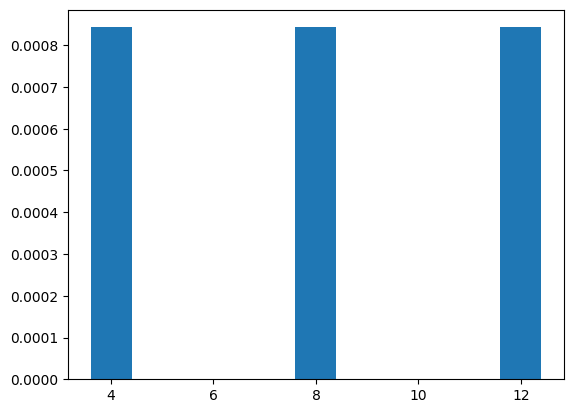

In [8]:
# write list to JSON file
temp_json_amenities = []
for amenity in amenities_pref:
    temp_json_amenities.append({'amenities_pref': amenity})

with open('temp_amenities_pref.json', 'w') as f:
    json.dump(temp_json_amenities, f)

amenities_pref_df = spark.read.json('temp_amenities_pref.json')

usr_rating = amenities_rating(spark, amenities_pref_df, hotel_amenity_df)
rank, error, errors, usrid_s2, model = model_train(spark, usr_rating)

print("best rank : ",rank)
print("best RMSE:" +str(error))
plt.bar([4,8,12], height=errors)

## Getting Recommendation

In [9]:
# check if model is None
model

ALSModel: uid=ALS_876ba1e6756b, rank=12

In [23]:
a_df = amenities_pref_df
a_df.createOrReplaceTempView('a_df')

# hotel_amenity_df.createOrReplaceTempView('temp_hotel_amenity_df')
# newa_df = spark.sql("SELECT * FROM hotel_amenity_df INNER JOIN a_df WHERE hotel_amenity_df.amenities=a_df.amenities_pref")

# amenity_combo = newa_df.groupBy(functions.col("id")).agg(functions.collect_list( functions.col("amenities")).alias("amenities"))

# amenities_len=amenity_combo.withColumn("ameni_len",functions.size(amenity_combo["amenities"])).orderBy(functions.col("ameni_len"), ascending=False)
# amenities_len.createOrReplaceTempView("amenities_len")

# ameni_df = spark.sql("SELECT a.id,h.amenities,a.ameni_len FROM temp_hotel_amenity_df h INNER JOIN amenities_len a WHERE h.id=a.id ORDER BY a.ameni_len DESC")

# usr_rating = ameni_df.withColumn('rating', col('ameni_len'))

a_df.show()

+--------------------+
|      amenities_pref|
+--------------------+
|   Wheelchair Access|
|           Microwave|
|     Laundry Service|
|  Breakfast included|
|         Kitchenette|
| Business Centre ...|
+--------------------+



In [10]:
# usrid_s2.createOrReplaceTempView('usrid_s2')
# temp = spark.sql('select count(*) from usrid_s2')
# print(type(usrid_s2))
# print(type(hotel_df))

usr_rating.show()

+---+--------------------+---------+------+
| id|           amenities|ameni_len|rating|
+---+--------------------+---------+------+
|598|              Suites|        5|     5|
|598|                 Spa|        5|     5|
|598|    Nonsmoking rooms|        5|     5|
|151|    Nonsmoking rooms|        5|     5|
|598|         Kitchenette|        5|     5|
|151|        Family Rooms|        5|     5|
|598|        Family Rooms|        5|     5|
|151|   SelfServe Laundry|        5|     5|
|598| Refrigerator in ...|        5|     5|
|151| Pets Allowed  Do...|        5|     5|
|598|           Microwave|        5|     5|
|151|  Multilingual Staff|        5|     5|
|598|    Air conditioning|        5|     5|
|151|     Laundry Service|        5|     5|
|598|   Wheelchair Access|        5|     5|
|151| Conference Facil...|        5|     5|
|598|   SelfServe Laundry|        5|     5|
|151|  Breakfast included|        5|     5|
|598|         Public Wifi|        5|     5|
|151|          Restaurant|      

In [11]:
user = usrid_s2.select("user_id").distinct()
recomm = model.recommendForUserSubset(user,50)
recomm.createOrReplaceTempView('recomm')

recomm.show()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    111|[{1999, 4.998496}...|
+-------+--------------------+



In [11]:
u_tempdf = get_hotel_recc(spark, usrid_s2, model)
# hotel_df = hotel_df.join(u_tempdf, "id").withColumn("address",functions.lower(functions.col("address")))
hotel_df = hotel_df.join(u_tempdf, "id")
# user_location = place.value.lower()
hotel_sugg = hotel_df.where(hotel_df.city == place.value)
# hotel_sugg = hotel_df.where(hotel_df.address.contains(user_location))
recc = hotel_sugg.dropna().toPandas()

# hotel_df = spark.read.json(const.DIR_DATA_HOTEL)
# hotel_df.createOrReplaceTempView('hotel_df')

# hotel_temp_df = hotel_df.join(u_tempdf, "id")


# TODO:
# u_tempdf.createOrReplaceTempView('u_tempdf')
# temp = spark.sql('select * from u_tempdf limit 30')
# temp.show()

In [12]:
# hotel_df.createOrReplaceTempView('temp')
# a = spark.sql('select count(*) from temp')
# hotel_sugg.show()
# u_tempdf.show()
recc
# hotel_df.show()

,id,amenities,city,hotel_name,hotel_rating,location,price
0,1999,"[lodging, point_of_interest, establishment]",Hà Nội,Green Hostel,4.4,"(21.0382601, 105.8293268)",0
1,1999,"[lodging, point_of_interest, establishment]",Hà Nội,Saigon Sun Hotel 1,3.5,"(21.0195574, 105.8254407)",600000
2,1999,"[lodging, point_of_interest, establishment]",Hà Nội,Thanglong GTC Hanoi Hotel,3.7,"(21.0264139, 105.8368171)",0
3,1999,"[lodging, point_of_interest, establishment]",Hà Nội,Green Hostel,4.4,"(21.0382601, 105.8293268)",0
4,1999,"[lodging, point_of_interest, establishment]",Hà Nội,Saigon Sun Hotel 1,3.5,"(21.0195574, 105.8254407)",600000
...,...,...,...,...,...,...,...
179,2538,"[lodging, point_of_interest, establishment]",Hà Nội,Beryl Palace Hotel and Spa,4.0,"(21.0290368, 105.844965)",700000
180,2538,"[lodging, point_of_interest, establishment]",Hà Nội,Felice Hostel,4.0,"(21.031582, 105.844331)",0
181,2538,"[lodging, point_of_interest, establishment]",Hà Nội,Beryl Palace Hotel and Spa,4.0,"(21.0290368, 105.844965)",700000
182,2538,"[lodging, point_of_interest, establishment]",Hà Nội,Felice Hostel,4.0,"(21.031582, 105.844331)",0


In [13]:
%%capture
final = dict()
# final['address'] = recc[:5]['address'].values.tolist()
final['amenities'] = recc[:5]['amenities'].values.T.tolist()
# final['experience'] = recc[:5]['hotel_experience'].values.tolist()
final['name'] = recc[:5]['hotel_name'].values.tolist()
final['rating'] = recc[:5]['hotel_rating'].values.tolist()
final['location'] = [i[1:-1] for i in recc[:5]['location'].values.tolist()]
final['price'] = recc[:5]['price'].values.tolist()
final['image'] = [get_image(i) for i in recc[:5]['hotel_name'].values.tolist()]



In [15]:
final

{'amenities': [['lodging', 'point_of_interest', 'establishment'],
  ['lodging', 'point_of_interest', 'establishment'],
  ['lodging', 'point_of_interest', 'establishment'],
  ['lodging', 'point_of_interest', 'establishment'],
  ['lodging', 'point_of_interest', 'establishment']],
 'name': ['Green Hostel',
  'Saigon Sun Hotel 1',
  'Thanglong GTC Hanoi Hotel',
  'Green Hostel',
  'Saigon Sun Hotel 1'],
 'rating': [4.4, 3.5, 3.7, 4.4, 3.5],
 'location': ['21.0382601, 105.8293268',
  '21.0195574, 105.8254407',
  '21.0264139, 105.8368171',
  '21.0382601, 105.8293268',
  '21.0195574, 105.8254407'],
 'price': [0, 600000, 0, 0, 600000],
 'image': ['../assets/images/noimage.jpg', None, None, None, None]}

## Final Output

In [14]:
days = (end.value - start.value).days
tab_recc = get_hotel_output(days, final)
display(tab_recc)

KeyError: 'experience'